# Transfer Learning Challenge

Use a pre-trained deep learning vision model to predict [STL-10 dataset](https://cs.stanford.edu/~acoates/stl10/).

## Approach

The [STL-10 dataset](http://cs.stanford.edu/~acoates/stl10/) consists of 5,000 training images and 8,000 test images that are 96 by 96 with three color channels selected from the [ImageNet](http://www.image-net.org/) dataset. (It also includes 100,000 unlabeled images to be used for unsupervised learning, but I won't be using those.) There are an equal number of images in each of 10 classes (airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck) for both the train (500) and test (800) sets.

The challenge is to use [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) to create a model that predicts the classes as accurately as possible on the test set as a whole. It appears that the state of the art today is 78.66% accuracy. ([This site](https://martin-thoma.com/sota/), updated as of 2017-02, had a good list of top results for many standard datasets.) But that accuracy figure is for a different protocol than the one that I'm going to execute. That protocol entailed performing unsupervised learning on the unlabeled training images and then supervised learning on the labeled data using 10 pre-defined folds, each containing 1,000 images with the overall accuracy then reported as the average of the ten separately trained models. 

I'm going to train on all 5,000 training images, and instead of using the unlabeled images, I'm going to use weights from the pretrained [Resnet50 model](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py) included with [Pytorch](http://pytorch.org/docs/master/index.html) for transfer learning. Since Resnet50 was trained on the ImageNet dataset, the results should be excellent. I checked around the internet and found other results in the mid-90%'s using a similar approach.

I've completed Andrew Ng's original [Machine Learning course on Coursera](https://www.coursera.org/learn/machine-learning), his more recent [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning) and the first two lectures of the [fast.ai deep learning course](http://course.fast.ai/). I've also completed a couple of projects building and operationalizing models in the auto insurance space, but still consider myself fairly new to deep learning. I've used [Tensorflow](https://www.tensorflow.org/), [Keras](https://keras.io/) and the [scikit-learn](http://scikit-learn.org/stable/) before so I decided to tackle this challenge with [Pytorch](http://pytorch.org/).

## Setup

### Import packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import time
from tqdm import tnrange, tqdm_notebook
from stl10cse import STL10

### Specify data transforms

Here we set up the transforms. The means and standard deviations are those from the ImageNet dataset. We want to normalize our images using these so that normalization is consistent with the distribution of the images used to train the transfer learning model. The other thing that is important is to set the image size, below using `transforms.Resize`, to the size of the images the transfer learning model is expecting, in this case 224 x 224.

For the training set, I use various transformations in order to achieve the effect of augmentation as mini-batches are generated. The first transform is to convert the numpy arrays to PIL images, the format the most of the other transforms require. Then I pad the images and select a random crop to get some variability in object placement within the images followed by a random rotation of up to five degrees and lastly, a random horizontal flip.

In [2]:
means, stdvs = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
data_transforms = {
    'train': transforms.Compose([
        transforms.Pad(4),
        transforms.RandomCrop(96),
        transforms.Resize(224),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(means, stdvs)
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(means, stdvs)
    ])}

### Instantiate datasets

Pytorch has a bunch of [datasets](http://pytorch.org/docs/master/torchvision/datasets.html) available in its API. I needed the indices of the images from the dataloaders to be able to view the images associated with predictions from the model. I modified the Pytordch [STL10 dataset](https://github.com/pytorch/vision/blob/master/torchvision/datasets/stl10.py) and used that instead.

In [3]:
root_dir = 'data/stl10'
ds={x: STL10(root_dir, x, data_transforms[x]) for x in ['train', 'test']}

### Instantiate data loaders

Here we set up the data loaders, which are iterators that feed batches of data in to the training loop. I made sure the batch size small enough to fit in memory on my machine.

In [4]:
dl = {
    'train': DataLoader(ds['train'], 64, True, num_workers=4),
    'test': DataLoader(ds['test'], 64, False, num_workers=4)}

### Examine images

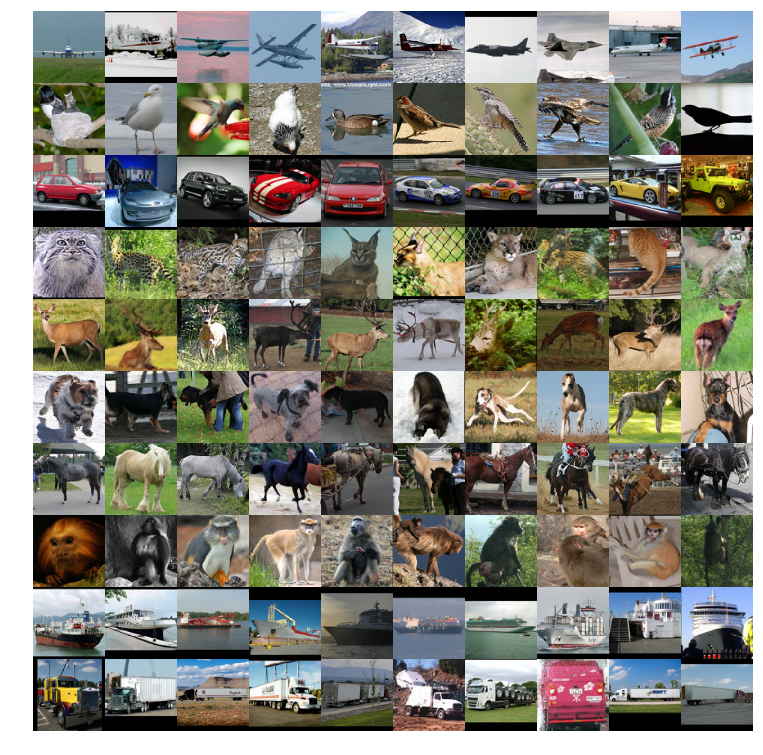

In [5]:
def imgt_to_imgp(imgt, title=None):
    imgp = imgt.numpy().transpose((1, 2, 0))
    mean = np.array(means)
    std = np.array(stdvs)
    imgp = std * imgp + mean
    imgp = np.clip(imgp, 0, 1)
    return imgp

np.random.seed(1)
rows, cols = 10, 10
fig = plt.figure(figsize=(rows, cols))
gs = gridspec.GridSpec(rows, cols, width_ratios=[1] * cols,
         wspace=0.0, hspace=0.0, top=1.0, bottom=0.0, left=0.0, right=1.0) 

for r in range(rows):
    idxs = np.random.choice(np.argwhere(ds['test'].labels == r).flatten(), (rows,))
    for c, idx in enumerate(idxs):
        img = imgt_to_imgp(ds['test'][idx][0])
        ax = plt.subplot(gs[r,c])
        ax.imshow(img)
        ax.axis('off')
        
plt.show()

Before moving on to the model, let's take a quick look at some of the test images.

It looks like the images are pretty well defined, although there do appear to be a few challening ones interspersed throughout. The cat in the fourth row and ninth column, for example, doesn't have the cat's head in it. The dog image in the sixth row and third column is mostly of a person's legs. The truck image in the last row and and eighth column is pretty close up and just of the rear of the truck. However, if there were a sufficient number of similar images in the dataset the transfer learning model was trained on, these issues shouldn't affect accuracy.

The grid is set up to pull images in from each class (in the rows) randomly, so you can look at a bunch of different images by commenting out the random seed and re-running.

## Training loop

This is pretty straightforwad and largely follows the [Pytorch Transfer Learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) with a few modfications. You basically feed in a model, a criterion (loss function), an optimization algorithm, and a number of epochs and get back the model that had the lowest loss on the test set from any of the epochs. For each epoch, it loops through the batches for both the training and test sets (only performing back propogation for the training set) and then updates the weights for the next batch. I added in some logic to store the indices, predictions and class probabilities for the test set in a data frame so that they could be analuyzed after training. I also added in some [progress bars](https://github.com/noamraph/tqdm).

I was running on an [Nvidia P5000 GPU](http://images.nvidia.com/content/pdf/quadro/data-sheets/192195-DS-NV-Quadro-P5000-US-12Sept-NV-FNL-WEB.pdf) at [Paperspace](https://www.paperspace.com/ml), which was cooking right along, but kept the cpu-only code so that it works without a gpu.

It seemed somewhat inefficient to run the predictions on the full 8,000 image test set with each epoch, but I left it as is since the model was training for so few epochs. It would have also been nice to have had separate development and test sets, but the accuracy of the model was so good, there wasn't a lot of development to be done.

In [6]:
dataset_sizes = {x: len(ds[x]) for x in ['train', 'test']}
class_names = ds['train'].classes
use_gpu = torch.cuda.is_available()

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    # set up tensor for storing prediction outputs from best epoch
    columns = list(range(len(class_names))) + ['idx', 'pred', 'label']
    preds_best = torch.FloatTensor(len(columns),1).zero_()
    if use_gpu:
        preds_best.cuda()
    
    for epoch in tnrange(num_epochs, desc='epochs:'):
        print('-'*10)
        print('epoch {}/{}:'.format(epoch + 1, num_epochs))
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train(True)
                scheduler.step()
            else:
                model.train(False)
                
                # set up tensor for storing prediction outputs from batch
                preds_e = torch.FloatTensor(1, len(columns)).zero_()
                if use_gpu:
                    preds_e = preds_e.cuda()

            running_loss = 0.0
            running_corrects = 0

            for data in dl[phase]:                    
                inputs, labels, idxs = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                    idxs = idxs.cuda()
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # concat prediction outputs for current batch
                if phase == 'test':
                    bs = len(idxs)
                    t1ds = (idxs, preds, labels.data)
                    preds_b = torch.cat(tuple(x.view(bs,1).float() for x in t1ds), 1)
                    preds_b = torch.cat((outputs.data, preds_b), 1)
                    preds_e = torch.cat((preds_e, preds_b), 0)

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{:>7}--> loss: {:6.4f} acc: {:6.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                preds_best = preds_e[1:]

    time_elapsed = time.time() - since
    print('training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('best test acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    torch.cuda.empty_cache()
    
    # create dataframe of prediction outputs
    if use_gpu:
        preds_best = preds_best.cpu()
    df_preds = pd.DataFrame(preds_best.numpy(), columns=columns).set_index('idx')
    df_preds.index = df_preds.index.astype(int)
    for col in ['pred', 'label']:
        df_preds[col] = df_preds[col].astype(int)
        df_preds['{}_cl'.format(col)] = df_preds[col].apply(lambda x: class_names[int(x)])
    df_preds['incorrect'] = df_preds.label != df_preds.pred
    
    return model, df_preds

## Model

I decided to use the [Resnet50](https://arxiv.org/abs/1512.03385) model since it was trained on the ImageNet data set, the same set the STL10 dataset was pulled from, and had great results in the literature. Also super cool that the model can be loaded directly from Pytorch's api (along with several other popular models, docs [here](http://pytorch.org/docs/0.3.0/torchvision/models.html?highlight=models)).

The only thing to do here is to indicate that we want to use the pretrained weights and then to replace the last fully connected layer with a new one with dimensions of our dataset. You can get the number of features being fed in to a layer with `.in_features`. I won't print it out here in the interest of brevity, but you can get a summary of the model with the keys of the layers with `print(model)`. In the case of resnet50, the last fully connected layer has a key of `fc`. The new layer needs to have the same number of features being fed into it as the original one, but with the number of output features equal to ten to correspond to our dataset, instead of the 1,000 in the original ImageNet dataset.

I stuck with cross entropy for the loss function and vanilla stochastic gradient descent for the optimizer.

In [7]:
model = models.resnet50(pretrained=True)
ftrs = model.fc.in_features
model.fc = nn.Linear(ftrs, len(ds['train'].classes))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if use_gpu:
    model = model.cuda()

## Train

Here, we train the model for ten epochs.

In [8]:
model, df_preds = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

HBox(children=(IntProgress(value=0, description='epochs:', max=10), HTML(value='')))

----------
epoch 1/10:
  train--> loss: 0.0160 acc: 0.7748
   test--> loss: 0.0035 acc: 0.9574
----------
epoch 2/10:
  train--> loss: 0.0030 acc: 0.9574
   test--> loss: 0.0020 acc: 0.9669
----------
epoch 3/10:
  train--> loss: 0.0019 acc: 0.9686
   test--> loss: 0.0017 acc: 0.9694
----------
epoch 4/10:
  train--> loss: 0.0014 acc: 0.9818
   test--> loss: 0.0014 acc: 0.9722
----------
epoch 5/10:
  train--> loss: 0.0011 acc: 0.9822
   test--> loss: 0.0015 acc: 0.9705
----------
epoch 6/10:
  train--> loss: 0.0009 acc: 0.9910
   test--> loss: 0.0013 acc: 0.9721
----------
epoch 7/10:
  train--> loss: 0.0007 acc: 0.9896
   test--> loss: 0.0012 acc: 0.9765
----------
epoch 8/10:
  train--> loss: 0.0007 acc: 0.9938
   test--> loss: 0.0012 acc: 0.9769
----------
epoch 9/10:
  train--> loss: 0.0006 acc: 0.9928
   test--> loss: 0.0012 acc: 0.9756
----------
epoch 10/10:
  train--> loss: 0.0005 acc: 0.9952
   test--> loss: 0.0012 acc: 0.9754

training complete in 10m 10s
best test acc: 0.97

In [9]:
# torch.save(model, 'model')

## Evaluate

Overall these are terrific results, with **97.7%** accuracy (recall). The best model was generated on the eighth epoch. It looks the model starts overfitting around that epoch, perhaps even a few epochs before where the training loss becomes less than the test loss.

In [10]:
print(classification_report(df_preds.label, df_preds.pred,
                            target_names=class_names, digits=3))

             precision    recall  f1-score   support

   airplane      0.990     0.989     0.989       800
       bird      0.983     0.983     0.983       800
        car      0.983     0.988     0.985       800
        cat      0.961     0.958     0.959       800
       deer      0.972     0.963     0.967       800
        dog      0.950     0.971     0.960       800
      horse      0.985     0.964     0.974       800
     monkey      0.979     0.988     0.983       800
       ship      0.984     0.996     0.990       800
      truck      0.984     0.971     0.977       800

avg / total      0.977     0.977     0.977      8000



## Analyze

### Incorrect classifications

It looks like our best class was `ship`, with only three incorrectly classified images, and our worst was `cat`, with 34 images incorrectly classified.

In [19]:
pd.DataFrame(df_preds.groupby(['label_cl'])
              .sum()['incorrect'].sort_values(ascending=True)
             .astype(int))

,incorrect
label_cl,
ship,3
airplane,9
car,10
monkey,10
bird,14
dog,23
truck,23
horse,29
deer,30


### Confusion matrix

From the confusion matrix below we can tell that the incorrectly classifed ship images were either classifed as truck or an airplane, which intuitively makes sense since airplanes and trucks are the most similar in appearance to airplances relative to the other classifications. The incorrect cat classifications are distributed more widely, across, deer, horse and monkey. Deer, our second worst class is an interesting one: the confusion with horse makes sense, but I would have thought a deer would have been more similar to a dog than a cat.

In [12]:
df_preds.groupby(['label_cl', 'pred_cl']).count()[0].unstack('pred_cl').fillna(0)

pred_cl,airplane,bird,car,cat,deer,dog,horse,monkey,ship,truck
label_cl,,,,,,,,,,
airplane,791.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
bird,1.0,786.0,0.0,4.0,1.0,3.0,0.0,5.0,0.0,0.0
car,1.0,0.0,790.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0
cat,0.0,1.0,0.0,766.0,10.0,16.0,0.0,7.0,0.0,0.0
deer,0.0,4.0,0.0,11.0,770.0,6.0,6.0,3.0,0.0,0.0
dog,0.0,2.0,0.0,13.0,2.0,777.0,5.0,1.0,0.0,0.0
horse,0.0,3.0,1.0,2.0,6.0,13.0,771.0,1.0,1.0,2.0
monkey,0.0,3.0,0.0,1.0,3.0,2.0,0.0,790.0,1.0,0.0
ship,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,797.0,1.0


### Review misclassified images

#### Ship

In [20]:
def imshow_preds(idxs):
    cols = len(idxs)
    
    fig = plt.figure(figsize=(5*cols,0.8*cols))
    
    for c, idx in enumerate(idxs):
        ax = fig.add_subplot(1, cols, c+1)
        img = imgt_to_imgp(ds['test'][idx][0])
        ax.axis('off')
        ax.imshow(img)

        iop = df_preds.iloc[idx]
        pred_score = iop[iop.pred]
        label_score = iop[iop.label]
        pred_title = '{:>5} {:4} {:.3f}'.format('pred:', class_names[iop.pred][:4], pred_score)
        label_title = '{:>5} {:4} {:.3f}'.format('label:', class_names[iop.label][:4], label_score)
        plt.title('idx: {}\n{}\n{}'.format(idx, label_title, pred_title), fontsize=18*cols/5.)
    
    plt.show()

In [14]:
def get_idxs(class_name):
    idxs = df_preds[(df_preds.label_cl == class_name) & (df_preds.incorrect == True)]
    idxs = idxs.sort_values(class_names.index(class_name))
    return list(idxs.index.astype(int))[:5]

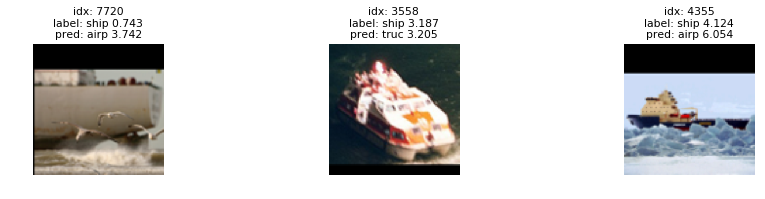

In [15]:
imshow_preds(get_idxs('ship'))

Let's take a look at some of the incorrectly classified images, starting with the three ship images. Each of these three images appear to have some aspects to them that would make them challenging to classify correctly. The first image is zoomed in very far, is a little blurry and happens to have some birds in it (that have wings like airplanes do). The second one is blurry and the contrast appears dark so the water is hard to distinguish. The icebergs in the last image are conspicous and obscure much of the ship.

The title on the images shows the index in the dataset, the correct label with score for that label and the predicted class with score. The images are sorted with the most incorrect furthest to the left. It's worth noting that the model was very close to predicting the correct class on all but the first image.

#### Deer

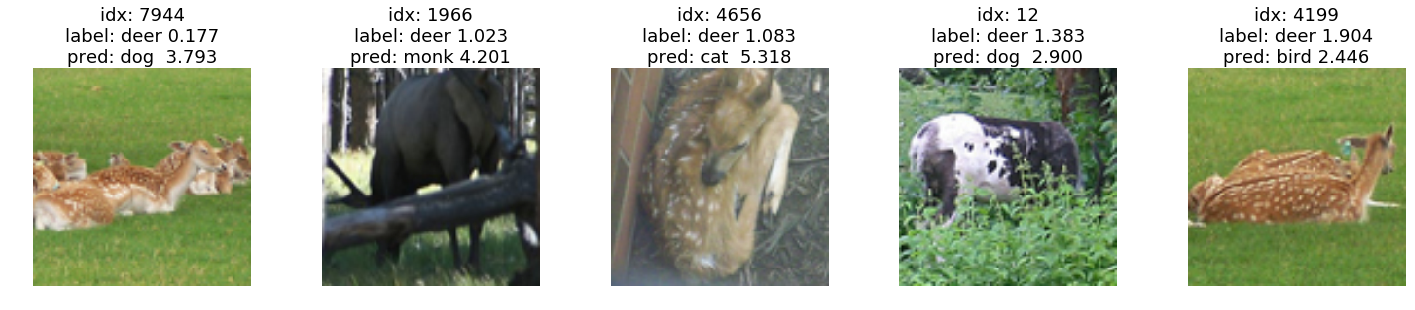

In [16]:
imshow_preds(get_idxs('deer'))

For the deer, the images with the lowest score for deer also appear to have some challenging aspects to them. The first could be perceived as being more similar to a dog given that the deer are so close to the ground and you can't see their long, deer-like legs. The second one is really dark and actually does look like a monkey at first glance. The last one interesting too - the fur on the deer does look feathery.

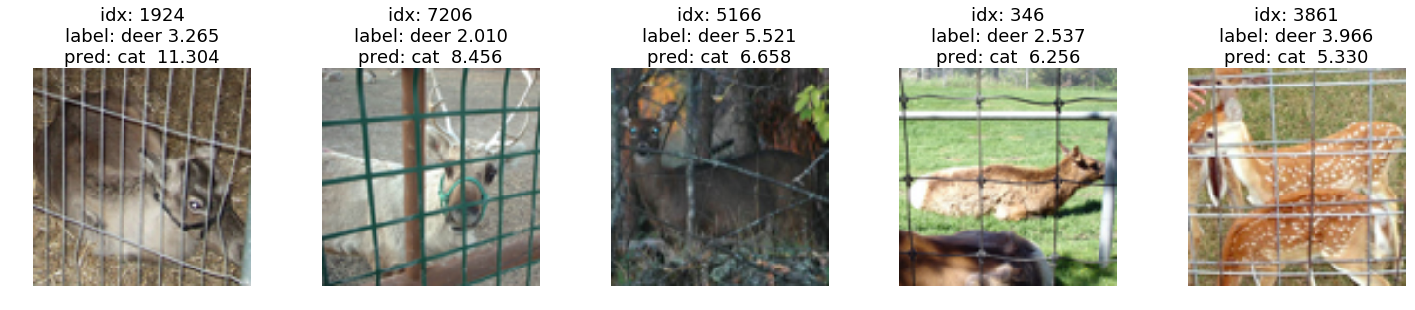

In [17]:
idxs = df_preds[(df_preds.label_cl == 'deer') & (df_preds.incorrect == True)]
idxs = idxs.sort_values(class_names.index('cat'), ascending=False)
idxs = list(idxs.index.astype(int))[:5]
imshow_preds(idxs)

Since `cat` was the most common misclassification for deer, let's take a look at the misclassifed deer images with the highest scores for `cat`. It's interesting that all of these pictures have some kind of meshed fence in them.

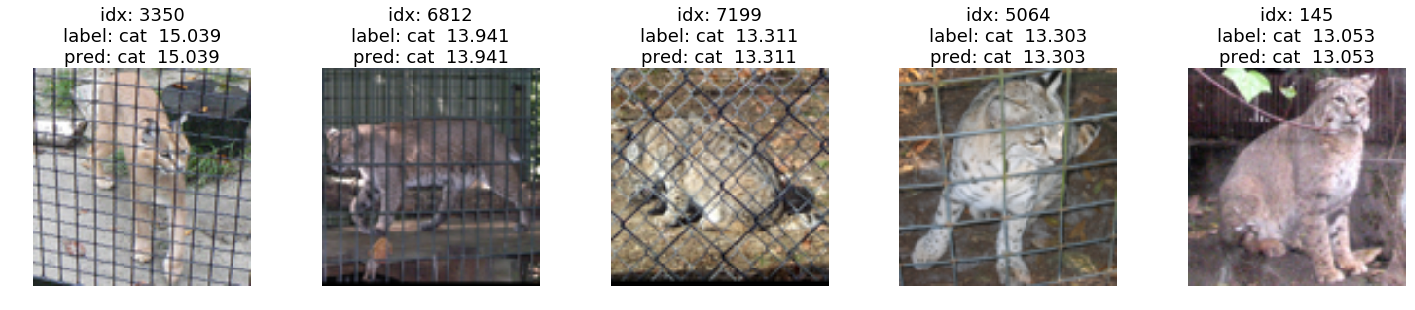

In [18]:
idxs = df_preds[(df_preds.label_cl == 'cat') & (df_preds.incorrect == False)]
idxs = idxs.sort_values(class_names.index('cat'), ascending=False)
idxs = list(idxs.index.astype(int))[:5]
imshow_preds(idxs)

Let's take a look at the cat pictures with the highest scores for `cat` and see whether they also have some sort of grid in them. Sure enough, there must have been a lot of images of 'cats' taken at zoos that were of bigger cats in cages and that is what is causing the model to key in on the cages or fences in the deer pictures - very cool. I wonder how you would deal with that from a model perspective. Could you figure out how the 'cage' feature was manifesting itself in the layers of the model and come up with a way to adjust for it?

## Conclusion

Transfer learning based on the Resnet50 model produced excellent results in classifying images in the STL10 dataset. I was impressed with absolute results of nearly 98%. However, part of the explanation for these great results has to be because the STL10 images are a subset of the ImageNet images the Resnet50 model was trained on. We are testing on images the model was trained on.

Working through the images after the model was trained was really fun. By analyzing a few different buckets of images, I was able to develop some intuitions around why the model might have been making the predictions it was.

I ended up really liking Pytorch. The process of constructing the Dataloader class and learning about how the training loop and model worked was valuable. There were a bunch of times where I was tracking down errors and appreciated that they referred to lines in my notebook that I could trace directly. The documentation was excellent. I like how tensors are moved explicitly on and off the gpu. I liked the mental model of thinking of it as something like numpy with gpu capabilities and a differntiation engine. ([This talk](https://www.youtube.com/watch?v=LAMwEJZqesU) by Souminth Chintala, one of the developers, was an excellent orientation.) Overall, even though it is a bit lower level than Keras, the mechanics of using it seem to be closer to the concepts I've learned in my courses and readings.